In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'cstr'

In [4]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False)

100%|██████████| 9/9 [00:00<00:00, 28.81it/s]


In [5]:
print(timeseries.head)
print(labels.head)
print(test_timeseries.head)
print(test_labels.head)

<bound method NDFrame.head of                       Caf        h     Qf        Ca           T   Tf  \
node_id    timestamp                                                   
node_1_15  0            1  5.99995  100.0  0.037237  402.352313  320   
           1            1  5.99995  100.0  0.037235  402.352942  320   
           2            1  5.99995  100.0  0.037232  402.353571  320   
           3            1  5.99995  100.0  0.037228  402.354565  320   
           4            1  5.99995  100.0  0.037222  402.356208  320   
...                   ...      ...    ...       ...         ...  ...   
node_9_117 112          1  5.99995  100.0  0.053391  395.494464  320   
           113          1  5.99995  100.0  0.053398  395.491153  320   
           114          1  5.99995  100.0  0.053371  395.498368  320   
           115          1  5.99995  100.0  0.053391  395.499842  320   
           116          1  5.99995  100.0  0.053386  395.495171  320   

                              Tc 

In [6]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
], verbose=True)

In [7]:
pipeline.fit(timeseries, labels)

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   3.9s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier(class_weight='balanced'))],
         verbose=True)

In [8]:
preds = pipeline.predict(test_timeseries)

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


In [9]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.8666967906146071
1 0.8947368421052632
2 0.8933333333333333
3 0.6637931034482759
4 0.8933333333333333
5 0.8933333333333333
6 0.9006622516556292
7 0.9006622516556292
8 0.7604166666666666
9 1.0


In [10]:
label_list = pipeline.steps[4][1].classes_
label_list[1]

2

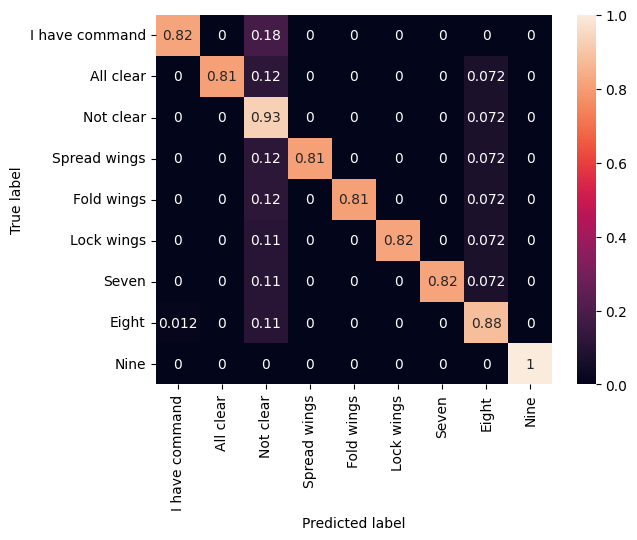

In [11]:
label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]    
label_dict = {'1': 'I have command',  '2': 'All clear',  '3': 'Not clear', '4': 'Spread wings', '5': 'Fold wings', '6': 'Lock wings', '7': 'Seven', '8': 'Eight', '9': 'Nine', }
text_labels = [label_dict[str(i)] for i in label_list]
sns.heatmap(cf, annot=True, xticklabels=text_labels, yticklabels=text_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [13]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 8 #UPDATE HERE FOR OTHER CLASSES
pred_select = 1 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_8_30', 596]]


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-02-16 16:52:51,760 INFO    Working on turning label from 8 to 2
/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precis

###########
['h', 'Q', 'Ca', 'T']
###########


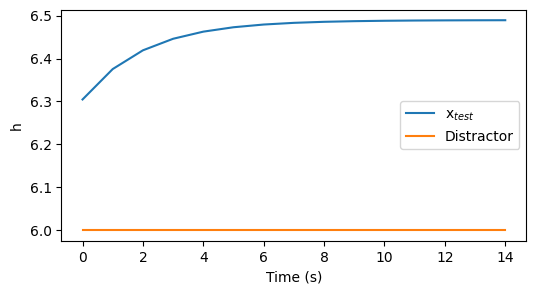

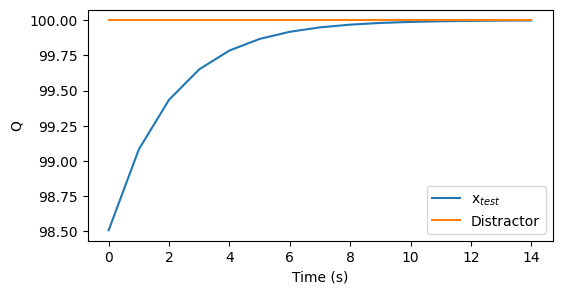

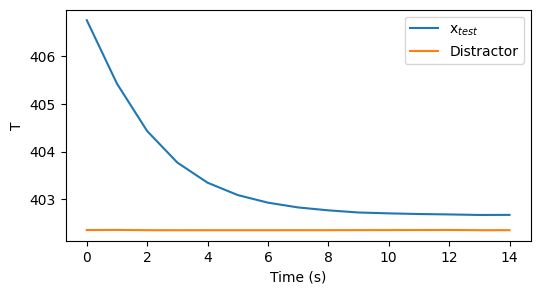

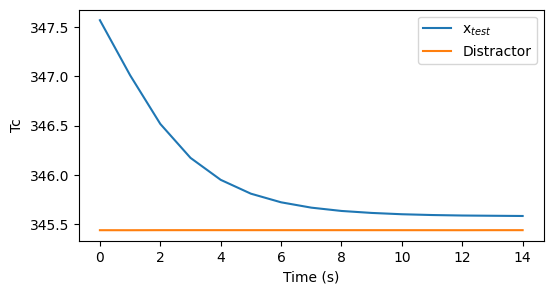

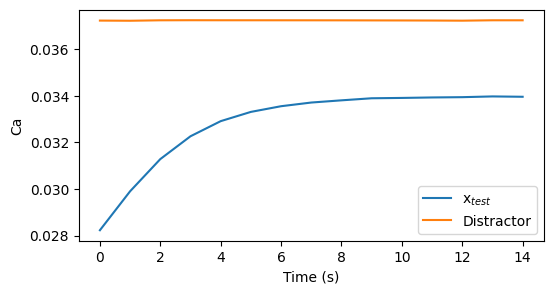

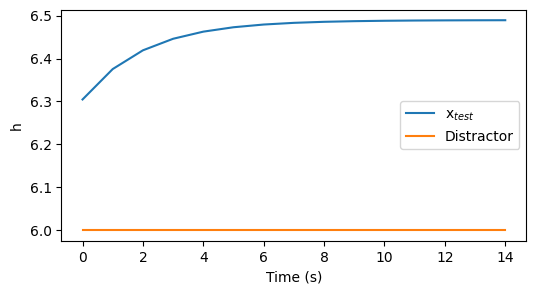

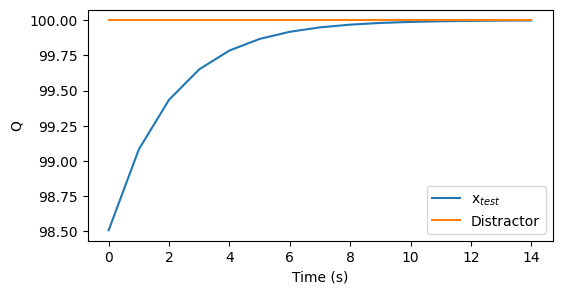

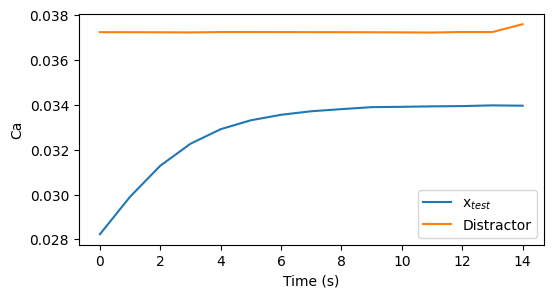

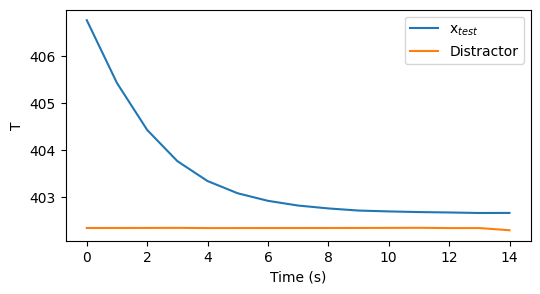

In [14]:
x_test = test_timeseries.loc[['node_8_46'], :, :]
explanation = comte.explain(x_test,to_maximize=pred_select,savefig=False) 
print('###########')
print(explanation)
print('###########')

In [15]:
# for node_id, ind in indices_test:
#     x_test = test_timeseries.loc[[node_id], :, :]
#     explanation = comte.explain(x_test,to_maximize=pred_select,savefig=False) 
#     print('###########')
#     print(explanation)
#     print('###########')
#     break